## 6. One-Hot Encoding

- 클래스가 2개일 때는 0 또는 1로 표현 가능
- 클래스가 3개 이상일 때는 한 벡터로 표현 불가능
    
    ⇒ **One-hot encoding** 사용
    
    예:
    
    클래스 1 → `[0, 1, 0]`
    
    클래스 2 → `[0, 0, 1]`
    

## 7. Cross Entropy Loss (다중 클래스 분류)

- 다중 클래스 분류에서는 출력 차원이 `(B, n)`
- 출력에 **Softmax 함수** 적용 → 각 클래스에 대한 확률 계산
- 이후 **Cross Entropy Loss** 계산:
    - One-hot encoding된 정답과 Softmax 출력 비교
    - 관심 있는 클래스의 확률만 선택해서 log 취함
    - 배치 전체에 대해 평균 적용하여 최종 Loss 계산

In [1]:
import pandas as pd

df = pd.read_csv('data/classify_3c_5k.csv')

data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

print(f'data: {data}, labels: {labels}')


data: [[ 0.09762701  0.43037873]
 [ 0.20552675  0.08976637]
 [-0.1526904   0.29178823]
 ...
 [ 0.47100447  0.10089364]
 [-0.20569733  0.51685904]
 [-0.95242515  0.62715016]], labels: [[1]
 [2]
 [1]
 ...
 [1]
 [2]
 [0]]


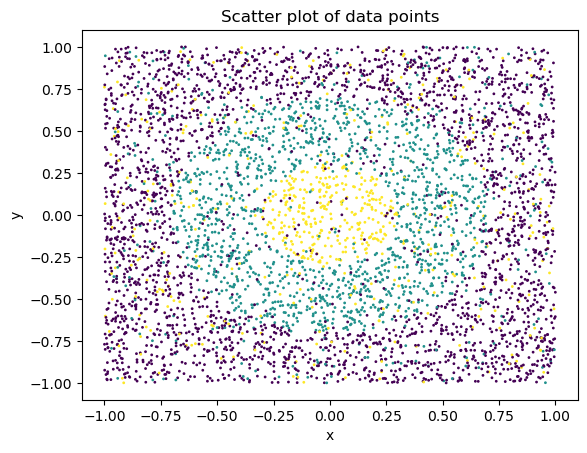

In [2]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=1)
plt.title('Scatter plot of data points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.long).reshape(-1)

# one-hot encoding으로 변환
labels_torch = F.one_hot(labels_torch)
print(labels_torch.size())

# 학습데이터를 7:3 정도로 train/validation으로 나누기
data_length = len(data_torch)
split_n = int(data_length * 0.7)
train_data = data_torch[:split_n]
train_labels = labels_torch[:split_n]
val_data = data_torch[split_n:]
val_labels = labels_torch[split_n:]


torch.Size([5000, 3])


In [23]:
g = torch.Generator().manual_seed(42)

# 배치로 데이터를 묶음(mini-batch)
def get_batch(x, y, batch_size):
  data_length = len(x)
  indices = torch.randint(0, data_length, (batch_size,), generator=g)

  x_batch = x[indices]
  y_batch = y[indices]
  return x_batch, y_batch

In [ ]:
# cross entropy loss 함수
def custom_cross_entropy_loss(output, one_hot_labels):
  exp_output = torch.exp(output)
  total = torch.sum(exp_output, dim=1, keepdim=True)
  softmax_output = exp_output / total
  log_prob = -torch.log(softmax_output)
  nll = (log_prob * one_hot_labels).sum(dim=1)
  return torch.mean(nll)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    # nn.Sequential을 사용하여 여러 레이어를 연결
    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, output_size),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  


net = Net(2, 4, 3)

# pytorch를 사용하면 더 정확하게 구현 가능
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  # loss = loss_fn(output, label_batch)
  loss = custom_cross_entropy_loss(output, label_batch)

  loss.backward()
  optimizer.step()

  optimizer.zero_grad()

  if steps % 1000 == 0:
    net.eval()
    output = net(val_data)

    # val_loss = loss_fn(output, val_labels)
    val_loss = custom_cross_entropy_loss(output, val_labels)
    print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 1.1055690050125122
1000 val_loss: 0.9568598866462708
2000 val_loss: 0.9568217992782593
3000 val_loss: 0.9561367034912109
4000 val_loss: 0.9559794664382935
5000 val_loss: 0.9555196166038513
6000 val_loss: 0.9541040062904358
7000 val_loss: 0.9520330429077148
8000 val_loss: 0.9484286904335022
9000 val_loss: 0.9425433874130249
10000 val_loss: 0.9323778748512268
11000 val_loss: 0.9144648313522339
12000 val_loss: 0.8787757158279419
13000 val_loss: 0.8057906031608582
14000 val_loss: 0.7607827186584473
15000 val_loss: 0.747480571269989
16000 val_loss: 0.741015613079071
17000 val_loss: 0.7375686168670654
18000 val_loss: 0.7341052889823914
19000 val_loss: 0.7329972982406616
20000 val_loss: 0.733921229839325
21000 val_loss: 0.7345578074455261
22000 val_loss: 0.7346861362457275
23000 val_loss: 0.7338702082633972
24000 val_loss: 0.7348986864089966
25000 val_loss: 0.7332813143730164
26000 val_loss: 0.7349510788917542
27000 val_loss: 0.7348122000694275
28000 val_loss: 0.734728217124939
29

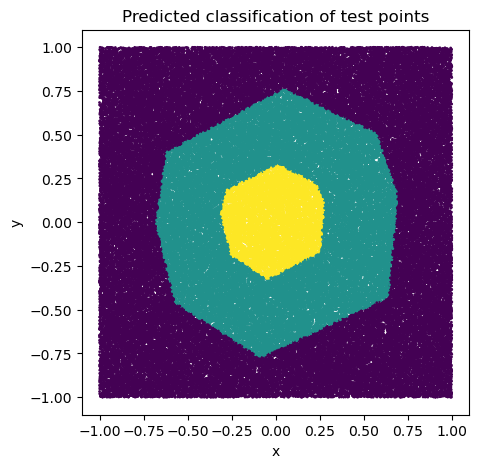

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

net.eval()
output_test = net(points_test_torch)

# softmax를 사용하여 확률로 변환
probability = torch.softmax(output_test, dim=1)
predictions = probability.argmax(dim=1)

prediction_np = predictions.numpy()

plt.figure(figsize=(5, 5))
plt.scatter(points_test[:, 0], points_test[:, 1], c=prediction_np, cmap='viridis', s=1)
plt.title('Predicted classification of test points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
